In [1]:
'''
Segment the OASIS brain data set with an Improved UNet.

@author Aghnia Prawira (45610240)
'''

import data_processing as dp
import improved_unet as iu
from importlib import reload
reload(dp)
reload(iu)

from glob import glob
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import random

In [2]:
# Set path to dataset
dataset_path = "keras_png_slices_data/"

seg_test_path = sorted(glob(dataset_path + "keras_png_slices_seg_test/*.png"))
seg_train_path = sorted(glob(dataset_path + "keras_png_slices_seg_train/*.png"))
seg_val_path = sorted(glob(dataset_path + "keras_png_slices_seg_validate/*.png"))
test_path = sorted(glob(dataset_path + "keras_png_slices_test/*.png"))
train_path = sorted(glob(dataset_path + "keras_png_slices_train/*.png"))
val_path = sorted(glob(dataset_path + "keras_png_slices_validate/*.png"))

In [3]:
train_ds = tf.data.Dataset.from_tensor_slices((train_path, seg_train_path))
val_ds = tf.data.Dataset.from_tensor_slices((val_path, seg_val_path))
test_ds = tf.data.Dataset.from_tensor_slices((test_path, seg_test_path))

In [4]:
# Load and process images
train_ds = train_ds.map(dp.process_image)
val_ds = val_ds.map(dp.process_image)
test_ds = test_ds.map(dp.process_image)

In [5]:
train, seg_train = next(iter(train_ds.batch(20)))
val, seg_val = next(iter(val_ds.batch(20)))
test, seg_test = next(iter(test_ds.batch(20)))

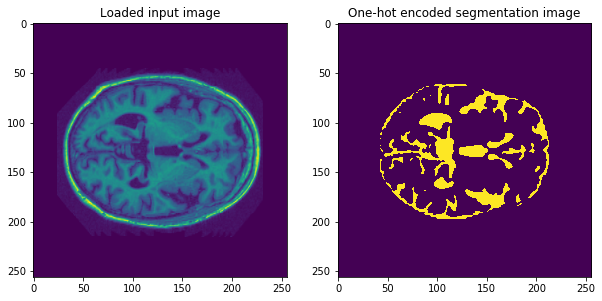

In [6]:
# Display loaded images
def display(title_list, image_list, cmap='viridis'):
    fig, ax = plt.subplots(1, len(title_list), figsize=(10, 10))
    for j, k in enumerate(title_list):
        ax[j].set_title(k)
    for j, k in enumerate(image_list):
        ax[j].imshow(k, cmap=cmap)
        plt.gray()
        
display(["Loaded input image", "One-hot encoded segmentation image"], [train[0][:,:,0], seg_train[0][:,:,1]])

In [7]:
print(np.array(train).shape)
print(np.array(seg_train).shape)

(20, 256, 256, 1)
(20, 256, 256, 4)


In [8]:
# Generate improved unet model
model = iu.unet()

In [9]:
# Compile the model
model.compile(optimizer='adam', 
              loss='binary_crossentropy', metrics=[iu.dice_coefficient_avg])

In [11]:
# Train the model
history = model.fit(train_ds.batch(20), 
                    epochs=8, 
                    validation_data=val_ds.batch(20))

Epoch 1/8
484/484 [==============================] - 194s 402ms/step - loss: 0.0793 - dice_coefficient_avg: 0.8992 - val_loss: 0.0667 - val_dice_coefficient_avg: 0.9244
Epoch 2/8
484/484 [==============================] - 226s 466ms/step - loss: 0.0394 - dice_coefficient_avg: 0.9516 - val_loss: 0.0499 - val_dice_coefficient_avg: 0.9417
Epoch 3/8
484/484 [==============================] - 209s 432ms/step - loss: 0.0308 - dice_coefficient_avg: 0.9623 - val_loss: 0.0445 - val_dice_coefficient_avg: 0.9503
Epoch 4/8
484/484 [==============================] - 181s 374ms/step - loss: 0.0269 - dice_coefficient_avg: 0.9672 - val_loss: 0.0368 - val_dice_coefficient_avg: 0.9590
Epoch 5/8
484/484 [==============================] - 214s 442ms/step - loss: 0.0248 - dice_coefficient_avg: 0.9699 - val_loss: 0.0340 - val_dice_coefficient_avg: 0.9631
Epoch 6/8
484/484 [==============================] - 240s 495ms/step - loss: 0.0235 - dice_coefficient_avg: 0.9716 - val_loss: 0.0336 - val_dice_coefficien

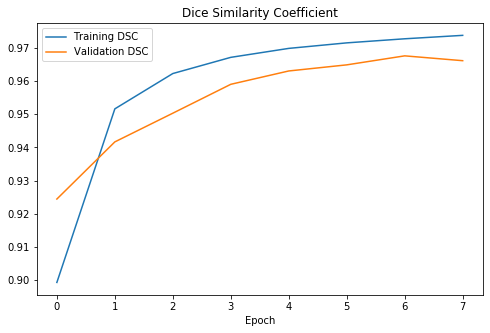

In [12]:
# Plot the training and validation DSC
plt.figure(figsize=(8, 5))
plt.title("Dice Similarity Coefficient")
plt.plot(history.history["dice_coefficient_avg"], label="Training DSC")
plt.plot(history.history["val_dice_coefficient_avg"], label="Validation DSC")
plt.xlabel("Epoch")
plt.legend();
plt.show()

In [13]:
# Calculate DSC
prediction = model.predict(test)
tf.print("Average DSC for all labels: ", iu.dice_coefficient_avg(seg_test, prediction))
tf.print("DSC for each label: ", iu.dice_coefficient(seg_test, prediction))

Average DSC for all labels:  0.961645305
DSC for each label:  [0.95819062 0.959171712 0.960060537 ... 0.962561607 0.963978648 0.964135051]


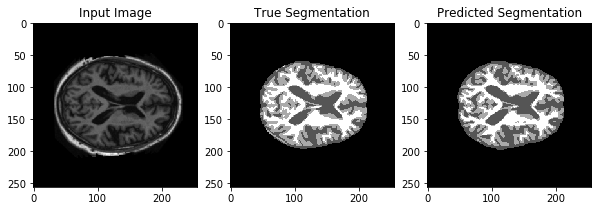

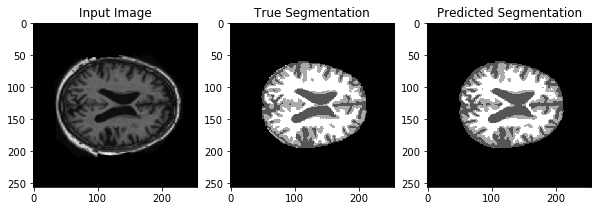

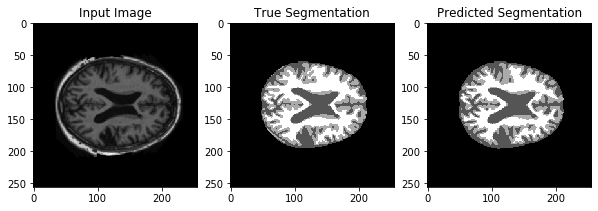

In [14]:
# Display random predictions
random_images = [random.randint(1,len(test)) for i in range(3)]

for i in random_images:
    display(['Input Image', 'True Segmentation', 'Predicted Segmentation'], 
            [test[i][:,:,0], tf.argmax(seg_test[i], axis=-1), tf.argmax(prediction[i], axis=-1)], cmap='gray')